<h1 align="center">Smart Home Sensor Analysis</h1>
<p>The ‘Household Power Consumption‘ dataset is a multivariate time series dataset that describes the electricity consumption for a single household over 2 years. The public dataset is available here - 
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

<p>The data was collected between December 2014 and December 2016 and observations of power consumption within the household were collected every minute. A modified version of this public data set along with simulated stream data will be used below to train and test the ML model for forecasdting.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

<b>global_active_power:</b> The total active power consumed by the household (kilowatts).<br>
<b>global_reactive_power:</b> The total reactive power consumed by the household (kilowatts).<br>
<b>voltage:</b> Average voltage (volts).<br>
<b>global_intensity:</b> Average current intensity (amps).<br>
<b>sub_metering_1:</b> Active energy for kitchen (watt-hours of active energy).<br>
<b>sub_metering_2:</b> Active energy for laundry (watt-hours of active energy).<br>
<b>sub_metering_3:</b> Active energy for climate control systems (watt-hours of active energy).<br>

<p> In the following section, we will develop and evaluate predictive models using <b>Long Short-Term memory Network</b> for the household power dataset. The purpose of this exercise is to demonstrate Sagemaker integration with IoT Analytics and not to focus on training the right model to generate accurate prediction.

<h2>Load and Prepare Dataset</h2>

<p> <u>Load the necessary libraries </u>

In [1]:
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
import matplotlib.pyplot as plt
import sys
import boto3
import pandas as pd
from sagemaker import get_execution_role
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from IPython.display import HTML

Using MXNet backend


In [2]:
try:
    import sklearn
except ImportError:
    !conda install -c conda-forge --yes --prefix {sys.prefix} scikit-learn
    


<h3>Load the data</h3>
<br>We can use the read_csv() function to load the data.  
<br> If there are any missing values, function fill_missing() will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [3]:
def parse(x):
    t= pd.to_datetime(str(x)) 
    timestring = t.strftime('%Y.%m.%d %H:%M:%S')
    return timestring

def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
 
# load all data

dataset = pd.read_csv("inputdata.csv",  header=0, low_memory=False, infer_datetime_format=True, date_parser = parse, index_col=['timestamp'])


<h3>Explore the data</h3>

<p> Since cost is already aggregated across Sub meters, we will retain only cost. We will aggregate the data daily so we can forecast the daily/weekly cost. The correlation matrix does not show 

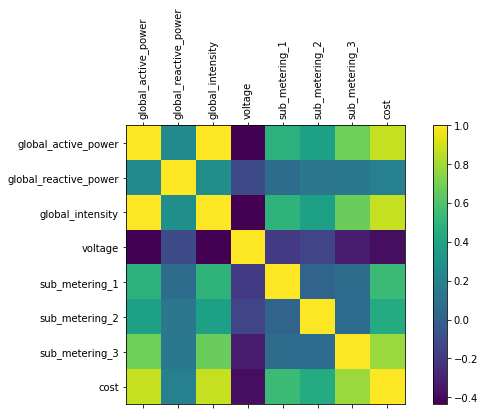

In [4]:

cor_cols = ["global_active_power","global_reactive_power", "global_intensity","voltage","sub_metering_1","sub_metering_2","sub_metering_3","cost"]


# plot correlation matrix
plt.figure(figsize=(10,5))

plt.matshow(dataset.loc[:, cor_cols].corr(), fignum=1)
plt.xticks(range(len(cor_cols)), cor_cols, rotation=90)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()


<p> The correlation plot, we can observe that Sub Meters 1 and 2 show some correlation with each other. Sub meter 3 has less correlation with Sub meter 1 and 2. Since cost is derived by aggregating Sub Meter 1, 2 and 3, we will retain only cost column to train the model.

In [5]:
analysis_cols = ["global_active_power","global_reactive_power", "global_intensity","voltage","cost"]

# select the value columns in the DataFrame to compare
dataset= dataset.loc[:, analysis_cols]



values = dataset.values


daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()


<p><h2>Training the model</h2>
<br>We will develop a simple or vanilla LSTM algorithm/model that reads in a sequence of days of total cost and predicts a vector output of the next standard week of daily cost.
<p><u>Split the dataset</u>
    <br>Function split_dataset() will split the dataset into Training and testing datasets, with a 70:30 ratio. Since we are looking to forecast weekly cost, the function will split the dataset by 7 and organize the data into standard weeks. 

In [6]:

from numpy import split
from numpy import array
from pandas import read_csv
 
    
def split_dataset(data):
    
    count=len(data)


    weeklyCount=round(count//7)

    modifiedCount=weeklyCount*7
    print("Dataset is modified to prepare for weekly split. The modified dataset count is",modifiedCount)


    modDf=data[0:modifiedCount]

    trainingCount=round(weeklyCount*0.7)*7
    train=data[0:trainingCount]

    test=data[trainingCount:modifiedCount]

    train = array(split(train, len(train)/7))   
    test = array(split(test, len(test)/7))
    print("Training data shape",train.shape)
    print("Testing data shape ",test.shape)
    return train, test    




<p>
In order to predict the next standard week, we need to retrieve the last days of observations. As with the training data, we must first flatten the history data to remove the weekly structure so that we end up with eight parallel time series.

In [7]:
# convert windows of weekly multivariate data into a series of submeter 4
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 7] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series


<p>The build_model() below prepares the training data, defines the model, and fits the model on the training data, returning the fit model ready for making predictions.
<br>In this function, we will develop a model with a single hidden LSTM layer with 200 units.  The LSTM layer is followed by a fully connected layer with 200 nodes that will interpret the features learned by the LSTM layer. Finally, an output layer will directly predict a vector with seven elements, one for each day in the output sequence. We will use the mean squared error loss function as a good match for our chosen error metric of RMSE. We will use the efficient Adam implementation of stochastic gradient descent and fit the model for 25 epochs with a batch size of 5. Ideally, for better results, you can change the Epochs to higher number, such as 70 and increase the batch size, e.g. to 16 or 25. Since we have limited time for the workshop, we are opted for smaller epoch and batch size. 



In [8]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 5    

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features),unroll=False))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


<p>Function to_supervised() takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [9]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 4] 
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 4]) 
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [10]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)

    # history is a list of weekly data
    history = [x for x in train]

    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
    # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)

    score, scores = evaluate_forecasts(test[:, :, 4], predictions) 
    return score, scores,predictions


<p>The forecast() function  make a prediction using the fit model and the input data and retrieve the vector of seven days of output. The function takes as arguments the model fit on the training dataset, the history of data observed so far, and the number of input time steps expected by the model

In [11]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 4]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [12]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [13]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('score %s:  %s' % (name,  s_scores))

<h2>Tie it all together</h2>
 <p>You may see some user warnings when you run this code. These are specific to MXNet Backend code while running the LSTM model and will be ignored.

In [14]:
train, test = split_dataset(daily_data.values)
# evaluate model and get scores
n_input = 7
score, scores,predictions = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)


Dataset is modified to prepare for weekly split. The modified dataset count is 175
Training data shape (18, 7, 5)
Testing data shape  (7, 7, 5)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:426: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.2). Is this intended?
  force_init=force_init)


score lstm:  20809.5, 23523.9, 17694.1, 20713.0, 24606.6, 18119.2, 24537.4


<h2>Results</h2>



<p>Running the example fits and evaluates the model, printing the overall RMSE across all seven days, and the per-day RMSE for each lead time.

In [15]:
display(HTML("<p>We can see that our model has printed overall RMSE of <b> "+str(score)+ "</b>."))

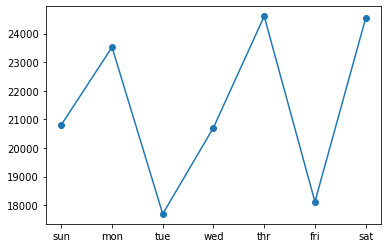

In [16]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

<p>A plot of the daily RMSE is also created.  .We can better predict cost for weekdays which have lower RMSE.
    
If you would like to understand more about LSTM model development and the methods used above, please refer to here : 

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/